In [78]:
import os
import warnings
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [79]:
@dataclass(kw_only=True)
class ShearData:
    path: str | None = None

    name: str | None = None
    type: str | None = None
    structured: bool | None = False
    uts: float | None = None
    dist_at_uts: float | None = None
    break_idx: int | None = None

    distance: np.ndarray | None = None
    force: np.ndarray | None = None
    distance_raw: np.ndarray | None = None
    force_raw: np.ndarray | None = None

    def load(self, break_threshold: float = 0.11) -> None:
        df = pd.read_csv(self.path, sep=";", skiprows=1, decimal=".", header=None)
        self.distance_raw = np.array(df[0])[:-10]
        self.force_raw = np.array(df[1])[:-10]
        self.name = self.path.split("/")[-1].split(".")[0]
        self.type = self.path.split("/")[-2]
        self.structured = self.name[0] == "s"
        self._calculate(break_threshold)

    def _calculate(self, break_threshold: float) -> None:
        self.break_idx = self._break_idx(break_threshold)
        self.uts = self.force_raw[self.break_idx]
        self.dist_at_uts = self.distance_raw[self.break_idx]
        self.distance = self.distance_raw[:self.break_idx]
        self.force = self.force_raw[:self.break_idx]

    def _break_idx(self, percent_change: float) -> int:
        """Return the last index before the force drops more than the specified amount."""
        max_force = np.max(self.force_raw)
        drop = max_force * percent_change
        changes = np.diff(self.force_raw)
        idx = np.where(changes < -drop)
        if len(idx[0]) == 0:
            return len(self.force_raw) - 1
        idx = idx[0][0] - 1
        if idx < 0.6 * len(self.force_raw):
            warnings.warn(
                f"Break index is at {idx} which is less than 60% of the data. You might want to check the break threshold.",
                UserWarning)
        return idx

In [80]:
def get_files(path: str) -> list:
    files = os.listdir(path)
    files = [f for f in files if f.endswith(".txt")]
    return files


def load_set(path: str) -> list:
    files = get_files(path)
    data = []
    for file in files:
        this_data = ShearData(path=path + file)
        this_data.load()
        data.append(this_data)
    return data


def plot_set(data: list,
             show_raw: bool = True) -> None:
    sns.set_context("paper")
    sns.set_theme(font="times new roman", style="whitegrid")
    path = data[0].path
    fig, axs = plt.subplots(1, figsize=(12, 6))
    if show_raw:
        for d in data:
            axs.plot(d.distance_raw,
                     d.force_raw,
                     color="r" if d.structured else "b",
                     label=None,
                     linewidth=0.6)
            axs.scatter(d.dist_at_uts, d.uts, color="g")
    else:
        for d in data:
            axs.plot(d.distance,
                     d.force,
                     color="r" if d.structured else "b",
                     label=None,
                     linewidth=0.6)

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color="r", lw=2),
                    Line2D([0], [0], color="b", lw=2)]
    plt.legend(custom_lines, ["Structured", "Unstructured"])
    plt.xlabel("Distance [mm]")
    plt.ylabel("Force [N]")
    plt.title(path.split("/")[-2])
    if not show_raw: plt.savefig(path.replace("02_Data", "06_Results") + "line_plots.svg")


def to_df(*data: list) -> pd.DataFrame:
    datas = []
    for d in data:
        for elem in d:
            type_names = {"tensile": "Tensile test",
                          "fourPoint": "Four-point \nbending",
                          "threePoint": "Three-point \nbending"}
            datas.append({"name": elem.name,
                          "Test type": type_names[elem.type],
                          "Structured": "Structured" if elem.structured else "Unstructured",
                          "Force at break in N": elem.uts,
                          "Distance at break in mm": elem.dist_at_uts})
    return pd.DataFrame(datas)

In [81]:
path = "../../02_Data/MechanicalTests/"
tensile = load_set(path + "tensile/")
four_point = load_set(path + "fourPoint/")
three_point = load_set(path + "threePoint/")

C:\Users\malte\AppData\Local\Temp\ipykernel_17028\1460444710.py:43: UserWarning: Break index is at 411 which is less than 60% of the data. You might want to check the break threshold.
  warnings.warn(


In [85]:
data = to_df(
        # tensile, 
        three_point,
        four_point)

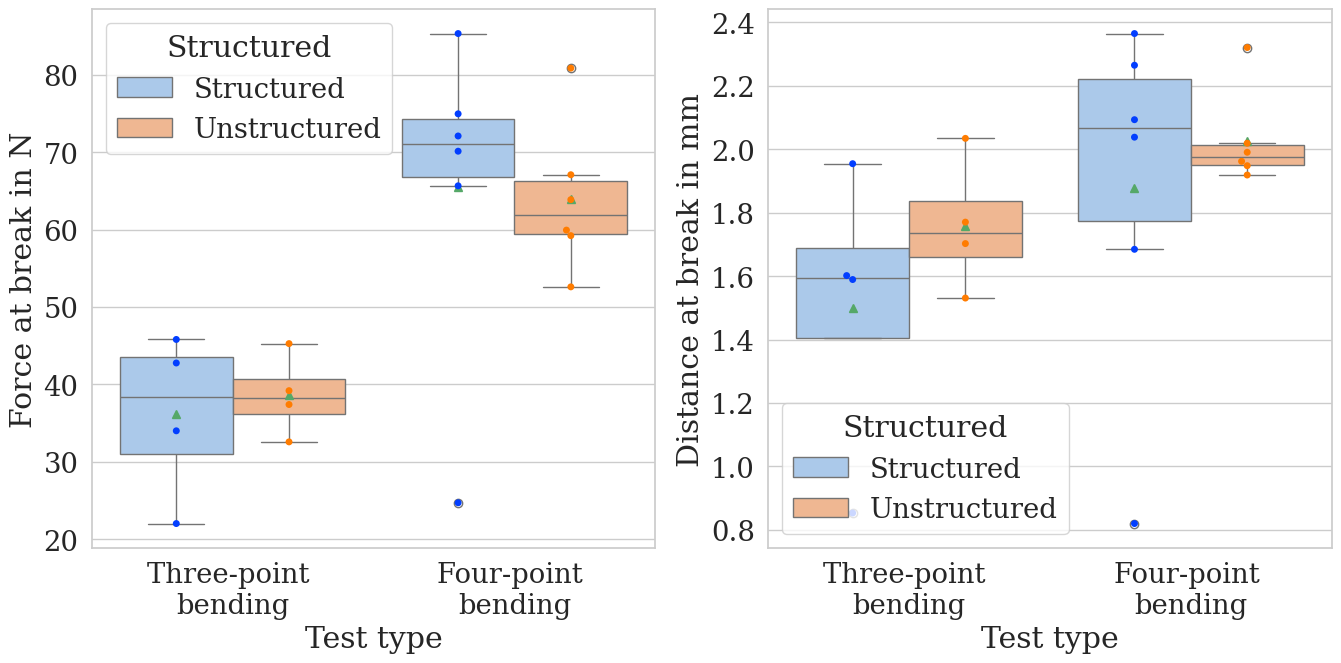

In [87]:
sns.set_theme(font_scale=1.8, font="serif", style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(x="Test type",
            y="Force at break in N",
            hue="Structured",
            data=data,
            ax=axs[0],
            showmeans=True,
            legend=True,
            palette="pastel")
sns.swarmplot(x="Test type",
              y="Force at break in N",
              hue="Structured",
              data=data,
              dodge=True,
              ax=axs[0],
              legend=False,
              palette="bright")
sns.boxplot(x="Test type",
            y="Distance at break in mm",
            hue="Structured",
            data=data,
            ax=axs[1],
            showmeans=True,
            palette="pastel")
sns.swarmplot(x="Test type",
              y="Distance at break in mm",
              hue="Structured",
              data=data,
              dodge=True,
              ax=axs[1],
              legend=False,
              palette="bright")
plt.savefig(path.replace("02_Data", "06_Results") + "box_plots.pdf")

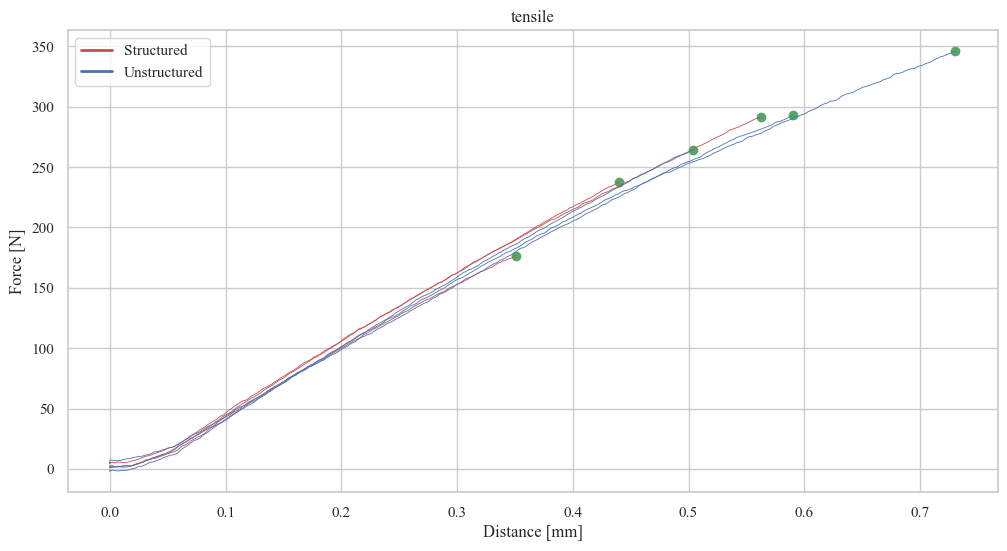

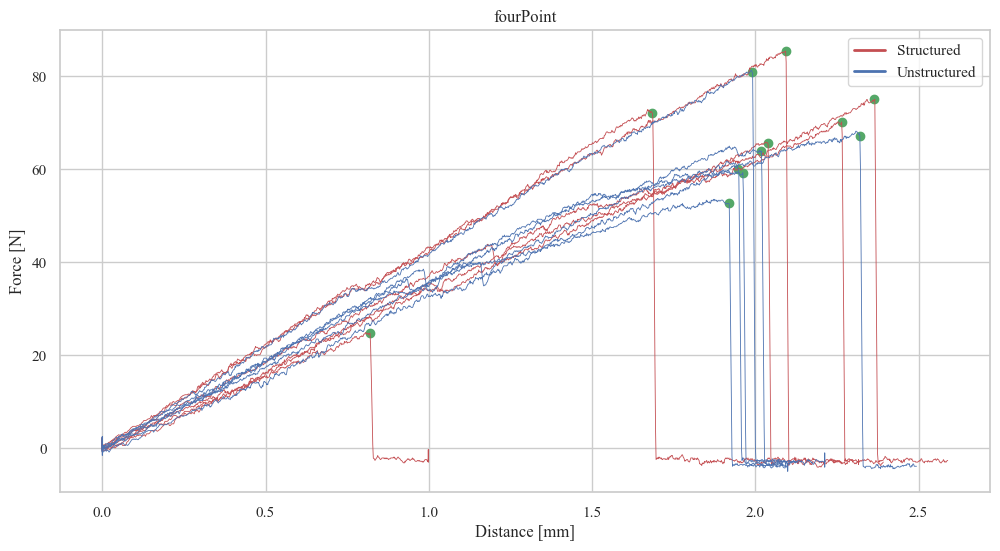

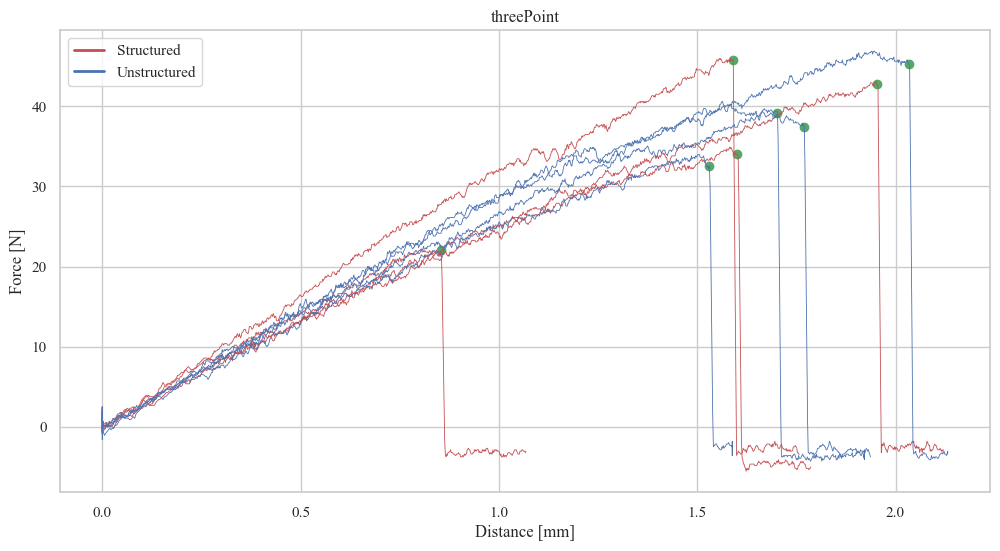

In [84]:
plot_set(tensile)
plot_set(four_point)
plot_set(three_point)